# DiagVI for integration of spatial and dissociated data

## Preliminaries
### Import packages and data

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import warnings

import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq

from scvi.external import DIAGVI

In [23]:
sc.settings.set_figure_params(scanpy=True, frameon=False, fontsize=10)

### Load Data

In [24]:
ad_sp = sc.read(
    "data/spatial_data.h5ad", backup_url="https://figshare.com/ndownloader/files/54145250"
)
ad_sp

AnnData object with n_obs × n_vars = 51787 × 351
    obs: 'embryo', 'pos', 'z', 'embryo_pos', 'embryo_pos_z', 'Area', 'celltype_seqfish', 'sample_seqfish', 'umap_density_sample', 'modality', 'total_counts', 'n_counts', 'celltype_harmonized'
    uns: 'celltype_harmonized_colors', 'celltype_seqfish_colors', 'embryo_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_orig', 'spatial'
    varm: 'PCs'

In [25]:
ad_diss = sc.read(
    "data/dissociated_data.h5ad", backup_url="https://figshare.com/ndownloader/files/54145217"
)
ad_diss

AnnData object with n_obs × n_vars = 16496 × 18499
    obs: 'barcode', 'sample_rna', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype_rna', 'haem_subclust', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutDPT', 'endo_gutCluster', 'sizefactor', 'modality', 'total_counts', 'n_counts', 'celltype_harmonized'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_harmonized_colors', 'celltype_rna_colors', 'cluster_colors', 'hvg', 'pca', 'sample_colors', 'sequencing.batch_colors', 'stage_colors', 'theiler_colors', 'umap'
    obsm: 'X_endo_gephi', 'X_endo_gut', 'X_haem_gephi', 'X_pca', 'X_umap', 'X_umap_orig'
    varm: 'PCs'

### Basic preprocessing

In [26]:
ad_sp.layers["counts"] = ad_sp.X.copy()
ad_sp.var["original_feature_name"] = ad_sp.var.index.copy()

sc.pp.normalize_total(ad_sp, target_sum=1e4)
sc.pp.log1p(ad_sp)

In [27]:
ad_diss.layers["counts"] = ad_diss.X.copy()
ad_diss.var["original_feature_name"] = ad_diss.var.index.copy()

sc.pp.normalize_total(ad_diss, target_sum=1e4)
sc.pp.log1p(ad_diss)
sc.pp.highly_variable_genes(ad_diss)

print(f"This computed {ad_diss.var['highly_variable'].sum()} highly variable genes")

This computed 1677 highly variable genes


In [28]:
genes_diss = ad_sp.var_names.union(ad_diss.var.query("highly_variable").index).intersection(
    ad_diss.var_names
)
ad_diss = ad_diss[:, genes_diss].copy()

In [29]:
print(f"Spatial data dimensions: {ad_sp.shape}")
print(f"Dissociated data dimensions: {ad_diss.shape}")

Spatial data dimensions: (51787, 351)
Dissociated data dimensions: (16496, 1780)


### Basic visualization

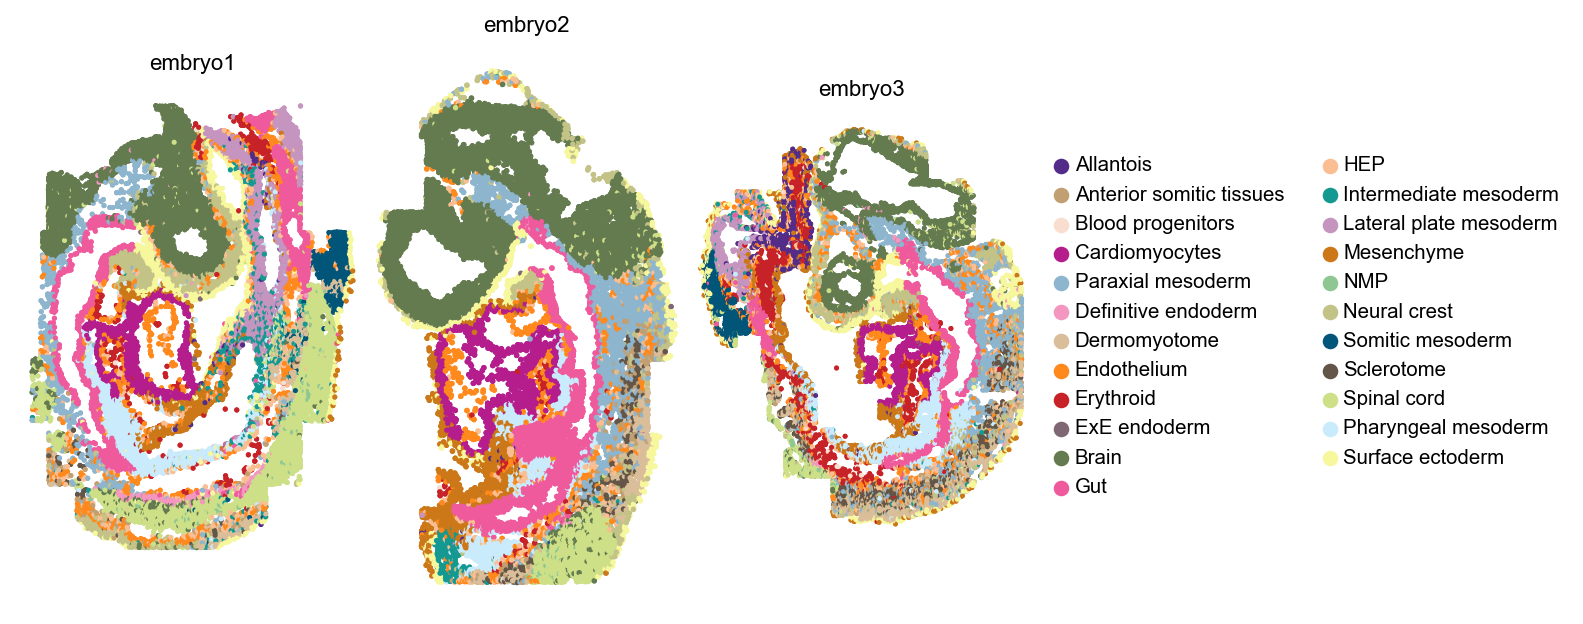

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    keys = ad_sp.obs["embryo"].cat.categories

    _, axes = plt.subplots(1, len(keys), figsize=(len(keys) * 2 + 4, 4))

    for i, (ax, cat) in enumerate(zip(axes, keys, strict=True)):
        obs_mask = ad_sp.obs["embryo"] == cat
        sq.pl.spatial_scatter(
            ad_sp[obs_mask],
            ax=ax,
            color="celltype_harmonized",
            title=cat,
            shape=None,
            library_id=None,
            legend_loc="right margin" if i == len(keys) - 1 else "none",
        )

    plt.tight_layout()

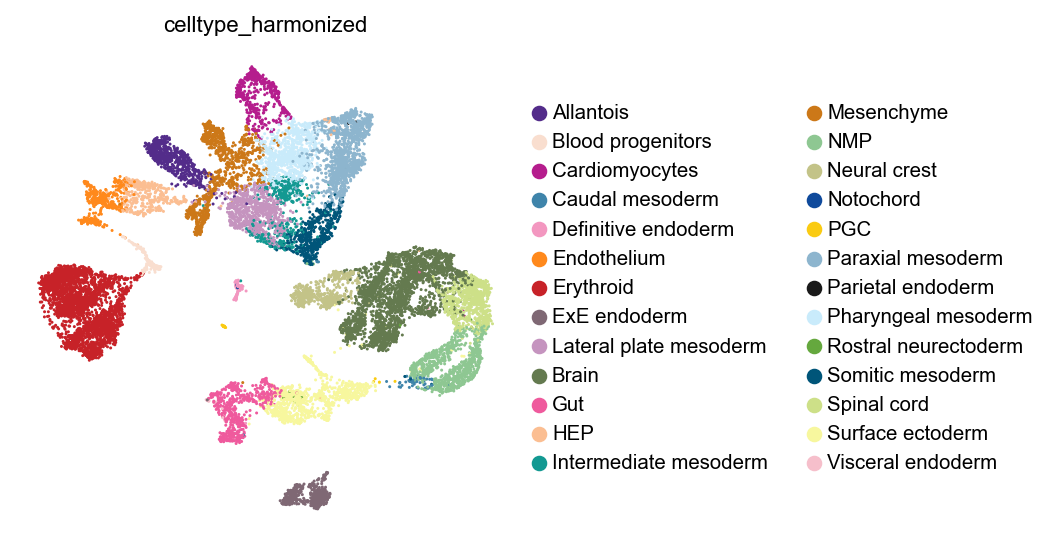

In [31]:
sc.pl.embedding(ad_diss, basis="X_umap", color="celltype_harmonized")

### Prepare and train the model

In [32]:
DIAGVI.setup_anndata(ad_diss, layer="counts", batch_key="sample_rna", likelihood="nb")

DIAGVI.setup_anndata(ad_sp, layer="counts", batch_key="embryo", likelihood="nb")

In [33]:
model = DIAGVI({"scRNAseq": ad_diss, "seqFISH": ad_sp})

INFO     Guidance graph consistency checks passed.                              


### Train the model

In [34]:
model.train(
    max_epochs=10,
    batch_size=256,
    accelerator="mps",
    plan_kwargs={
        "lam_kl": 1,
        "lam_data": 0.1,
        "lam_graph": 10.0,
        "lam_sinkhorn": 40,
        "lam_class": 0,
        "sinkhorn_p": 1,
        "sinkhorn_blur": 1,
        "sinkhorn_reach": 1,
    },
)

/Users/hannahwinter/Documents/ETH/MasterThesis/scvi-tools/src/scvi/external/diagvi/_model.py:169: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch/Jax operations are supported with this backend. as a result, some models might be slower and less accurate than usuall. Please verify your analysis!Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  accelerator, devices, device = parse_device_args(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniforge/base/envs/diag-test-env/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniforge/base/envs/diag-test-env/lib/python3.13/site-packa

Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


### Evaluate the trained model

In [35]:
latents = model.get_latent_representation()

In [36]:
emb_key = "X_diagvi"

ad_diss.obsm[emb_key] = latents["scRNAseq"]
ad_sp.obsm[emb_key] = latents["seqFISH"]

In [37]:
combined = sc.concat([ad_diss, ad_sp], axis=0, join="inner")

In [38]:
# take care of the colors
colors_diss = dict(
    zip(
        ad_diss.obs["celltype_harmonized"].cat.categories,
        ad_diss.uns["celltype_harmonized_colors"],
        strict=False,
    )
)
colors_sp = dict(
    zip(
        ad_sp.obs["celltype_harmonized"].cat.categories,
        ad_sp.uns["celltype_harmonized_colors"],
        strict=False,
    )
)

color_lookup = colors_diss | colors_sp
combined.uns["celltype_harmonized_colors"] = [
    color_lookup[cat] for cat in combined.obs["celltype_harmonized"].cat.categories
]

In [39]:
### compute and show embeddings function
key_added_umap = "X_umap_diagvi"

sc.pp.neighbors(combined, use_rep=emb_key, metric="cosine")
sc.tl.umap(combined, key_added=key_added_umap)

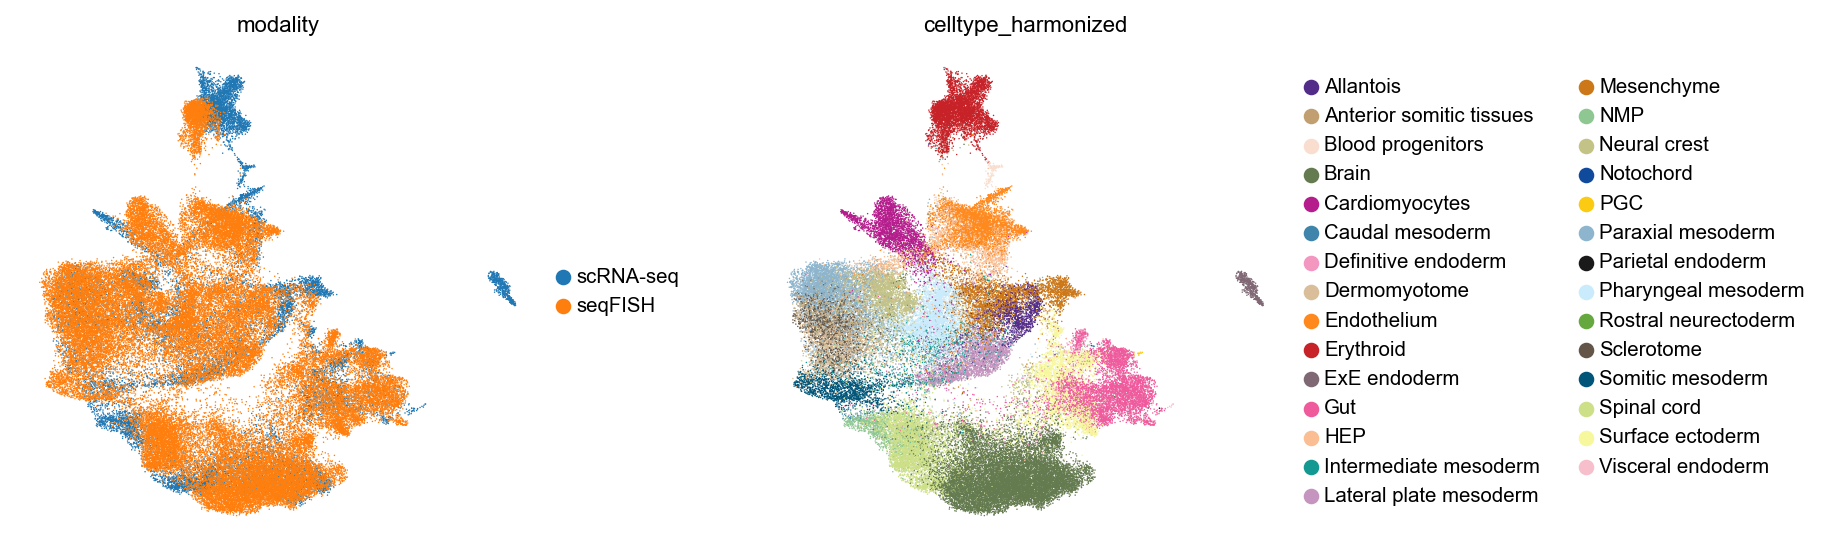

In [41]:
sc.pl.embedding(
    combined,
    basis="umap_diagvi",
    color=[
        "modality",
        "celltype_harmonized",
    ],
    wspace=0.3,
)